In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from functools import partial
from functools import reduce
from math import sqrt, pow, log, exp, sin

In [13]:

def data_parse(path: str):
    data = pd.read_csv(path)
    output = []
    for i in data.iloc():
        output.append((float(i.x), float(i.y)))
    return output


In [14]:
data_path='data.csv'
data = data_parse(data_path)


In [15]:
for item in data:
    print(f'x:{item[0]} f(x):{item[1]}')

x:0.142 f(x):5.642
x:0.494 f(x):4.096
x:0.847 f(x):3.39
x:1.199 f(x):2.924
x:1.5519999999999998 f(x):2.775
x:1.9040000000000001 f(x):2.5340000000000003
x:2.2569999999999997 f(x):2.418
x:2.609 f(x):2.405
x:2.9619999999999997 f(x):2.298


In [16]:
def mse(x1, x2):
    return sqrt(reduce(lambda x, y: x + (y[0] - y[1]) * (y[0] - y[1]), zip(x1, x2), 0))

# Data points

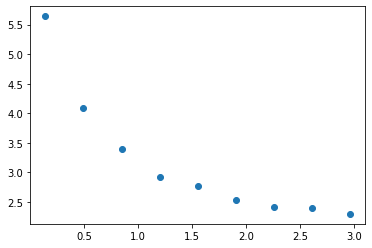

In [17]:

plt.scatter([item[0] for item in data], [item[1] for item in data])
plt.show()

## Interpolation funcs

In [18]:

def interpolate_lagrange(data: list):
    poly_size = len(data)
    denominator = [1 for i in range(poly_size)]
    for i in range(poly_size):
        for j in range(poly_size):
            denominator[i] *= data[i][0] - data[j][0] if not i == j else 1

    def fn(x):
        output = 0
        for i in range(poly_size):
            numerator = 1
            for j in range(poly_size):
                numerator *= x - data[j][0] if not i == j else 1
            output += data[i][1] * (numerator) / denominator[i]
        return output
    return fn

In [19]:

def devided_diff(data_points):
    if len(data_points) == 1:
        return data_points[0][1]
    return (devided_diff(data_points[1:]) - devided_diff(data_points[:-1])) / (data_points[-1][0] - data_points[0][0])

def interpolate_newton(data: list):
    devided_diffs = []
    for i in range(len(data)):
        devided_diffs.append(devided_diff(data[:(i + 1)]))
    def fn(x):
        result = 0
        for i in range(len(data)):
            part = 1
            for j in range(len(data) - 1):
                part *= (x - data[j][0])
            result += part * devided_diffs[i]
        return result
    return fn


In [20]:

def scipy_interpolation_fn_shell(kind='linear'):
    def build_fn(data: list):
        x = [item[0] for item in data]
        y = [item[1] for item in data]
        return interp1d(x, y, kind=kind)
    return build_fn


## Approximation funcs

In [21]:
def scipy_approximation_fn_shell(f):
    def build_fn(data: list):
        x = [item[0] for item in data]
        y = [item[1] for item in data]
        coef, coef_cov = curve_fit(f, x, y)
        print(f'coef {coef}')
        def result_fn(x):
            return f(x, *coef)
        return result_fn
    return build_fn

## Coefs from functions system

In [92]:
def from_fn_basis(fn_basis, *args):
    return lambda x: reduce(lambda x1, i: x1 + args[i] * fn_basis[i](x), range(len(fn_basis)), 0)


In [93]:
def get_coef(fn_basis, data):
    #Ax = b
    x_data = [item[0] for item in data]
    y_data = [item[1] for item in data]
    A = np.zeros((len(fn_basis), len(fn_basis)), dtype=float)
    b = np.zeros((len(fn_basis)), dtype=float)
    for i in range(len(fn_basis)):
        for j in range(len(fn_basis)):
            sum = 0
            for k in range(len(x_data)):
                sum += fn_basis[i](x_data[k]) * fn_basis[j](x_data[k])
            A[i, j] = sum
    for i in range(len(fn_basis)):
        sum = 0
        for k in range(len(x_data)):
            sum += fn_basis[i](x_data[k]) * y_data[k]
        b[i] = sum
    result = np.linalg.solve(A, b)
    return result


## Interpolation script

In [22]:
build_fn = scipy_interpolation_fn_shell(kind='cubic')

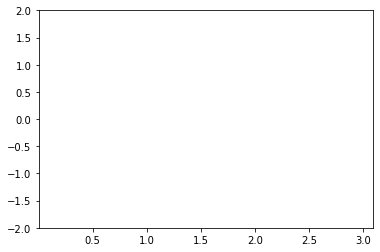

In [23]:
eps = 1e-6
interpolate_fn = build_fn(data)
start = min(data, key=lambda x: x[0])[0] + eps
stop = max(data, key=lambda x: x[0])[0] - eps
plt.plot(np.arange(start, stop, 0.01), [interpolate_fn(x) for x in np.arange(start, stop, 0.01)])
plt.ylim([-2, 2])
plt.show()

## test data points

a x:0.636 f(x):3.757451045365028
b x:0.318 f(x):4.711742823267339
c x:1.3755 f(x):2.835690085696062
d x:0.5646666666666665 f(x):3.9138127914596583


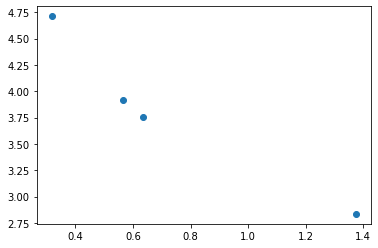

In [24]:
test_data_x = [data[0][0] + data[1][0], (data[0][0] + data[1][0]) / 2, (data[3][0] + data[4][0]) / 2, (data[0][0] + data[4][0]) / 3]
test_data_y = [interpolate_fn(x) for x in test_data_x]
symbols = ['a', 'b', 'c', 'd']
for i in range(len(test_data_x)):
    print(f'{symbols[i]} x:{test_data_x[i]} f(x):{test_data_y[i]}')
plt.scatter(test_data_x, test_data_y)
plt.show()

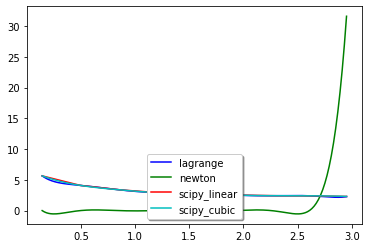

In [25]:
funcs = {'lagrange': interpolate_lagrange,'newton':interpolate_newton,
         'scipy_linear': scipy_interpolation_fn_shell(kind='linear'),'scipy_cubic': scipy_interpolation_fn_shell(kind='cubic')}
colors = iter(['b', 'g', 'r', 'c', 'm'])
fig, ax = plt.subplots()
for key, item in funcs.items():
    interpolate_fn = item(data)
    start = min(data, key=lambda x: x[0])[0] + eps
    stop = max(data, key=lambda x: x[0])[0] - eps
    ax.plot(np.arange(start, stop, 0.01), [interpolate_fn(x) for x in np.arange(start, stop, 0.01)], color=next(colors), label=key)

legend = ax.legend(loc='lower center', shadow=True, fontsize='medium')
plt.show()

## Approximation scripts

In [107]:
to_fit_fns = [
    lambda x, a, b, c: a * x * x + b * x + c, 
    lambda x, a, b, c: a / (x * x) + b / x + c, 
    lambda x, a, b, c: b * np.power(x, a) + c, 
    lambda x, a, b, c: b * np.exp(a * x) + c, 
    lambda x, a, b, c: b / (x + a) + c, 
    lambda x, a, b, c: a * x + b * np.exp(-x) + c, 
    lambda x, a, b, c: a / x + b * np.exp(x) + c, 
    lambda x, a, b, c: a * np.log(x) + b * np.exp(x) + c, 
    lambda x, a, b, c: b * np.exp(-a * (x + c) * (x + c)) + c,
    lambda x, a, b, c: a * np.sqrt(x) + b * np.sin(x) + c]
fn_basis_list = [[lambda x: x * x, lambda x: x, lambda x: 1],
                 [lambda x: np.sqrt(x), lambda x: np.sin(x), lambda x: 1],
                [lambda x: np.log(x), lambda x: exp(x), lambda x: 1]]

In [111]:
build_fn = scipy_approximation_fn_shell(to_fit_fns[7])
print('Function 10')
approx_fn = build_fn(data)

Function 10
coef [-1.25935501  0.0299682   3.13904909]


In [109]:
coefs = get_coef(fn_basis_list[2], data)
print(f'coef {coefs}')
approx_fn = from_fn_basis(fn_basis_list[2], *coefs)

coef [-1.25935501  0.0299682   3.13904909]


## Plot approximation

MSE: 0.13615809848876434


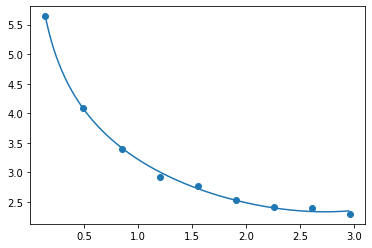

In [110]:
plt.scatter([item[0] for item in data], [item[1] for item in data])
start = min(data, key=lambda x: x[0])[0] + eps
stop = max(data, key=lambda x: x[0])[0] - eps
plt.plot(np.arange(start, stop, 0.01), [approx_fn(x) for x in np.arange(start, stop, 0.01)])
print(f'MSE: {mse([item[1] for item in data], [approx_fn(item[0]) for item in data])}')
plt.show()